In [1]:
import pickle
import pandas as pd
import numpy as np

## 데이터 불러오기

In [2]:
# pickle 파일 불러오기
with open('../processed/export_GDP_pop_fx.pkl', 'rb') as f:
    ratings_all = pickle.load(f)

ratings_all

,year,country,품목코드,수출금액,GDP,preference,GDP_growth,population,pop_growth,USD,JPY,EUR,CNY
0,2012,Afghanistan,3.0,1.0,2.020357e+07,4.949620e-08,NaN,30466479.0,NaN,1126.43,1412.96,1447.58,178.52
1,2012,Afghanistan,4.0,0.0,2.020357e+07,0.000000e+00,NaN,30466479.0,NaN,1126.43,1412.96,1447.58,178.52
2,2012,Afghanistan,7.0,2.0,2.020357e+07,9.899239e-08,NaN,30466479.0,NaN,1126.43,1412.96,1447.58,178.52
3,2012,Afghanistan,8.0,0.0,2.020357e+07,0.000000e+00,NaN,30466479.0,NaN,1126.43,1412.96,1447.58,178.52
4,2012,Afghanistan,10.0,12.0,2.020357e+07,5.939543e-07,NaN,30466479.0,NaN,1126.43,1412.96,1447.58,178.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116390,2021,Zimbabwe,87.0,1289.0,2.837124e+07,4.543334e-05,0.318998,15993524.0,0.020668,1145.07,1041.92,1353.40,177.56
116391,2021,Zimbabwe,90.0,322.0,2.837124e+07,1.134952e-05,0.318998,15993524.0,0.020668,1145.07,1041.92,1353.40,177.56
116392,2021,Zimbabwe,94.0,1.0,2.837124e+07,3.524696e-08,0.318998,15993524.0,0.020668,1145.07,1041.92,1353.40,177.56
116393,2021,Zimbabwe,95.0,13.0,2.837124e+07,4.582105e-07,0.318998,15993524.0,0.020668,1145.07,1041.92,1353.40,177.56


In [3]:
ratings = ratings_all[ratings_all['year']==2012]
ratings = ratings[['country', '품목코드', 'preference']]
# column명 변경
ratings.columns=['country_id', 'item_id', 'preference']

# country에 고유번호 부여하기
country_to_idx = {v:k for k,v in enumerate(ratings['country_id'].unique())}
idx_to_country = {v:k for k,v in country_to_idx.items()}

# country_id를 고유번호로 바꾸기
ratings['country_id'] = ratings['country_id'].map(country_to_idx)

# item_id int로 바꾸기
ratings['item_id'] = ratings['item_id'].astype(int)

# 중복제거
ratings = ratings.drop_duplicates(['country_id', 'item_id'], keep='first')

# index reset
ratings.reset_index(drop=True, inplace=True)
ratings


,country_id,item_id,preference
0,0,3,4.949620e-08
1,0,4,0.000000e+00
2,0,7,9.899239e-08
3,0,8,0.000000e+00
4,0,10,5.939543e-07
...,...,...,...
11021,202,91,0.000000e+00
11022,202,94,0.000000e+00
11023,202,95,8.764319e-07
11024,202,96,1.869721e-06


In [4]:
ratings.describe()

,country_id,item_id,preference
count,11026.000000,11026.000000,1.102600e+04
mean,103.854707,51.162253,2.220137e-04
std,57.936512,26.954398,3.713710e-03
min,0.000000,1.000000,0.000000e+00
25%,55.000000,29.000000,7.961139e-08
50%,102.500000,52.000000,1.914137e-06
75%,150.000000,73.000000,2.045958e-05
max,202.000000,97.000000,2.723372e-01


## UBCF_KNN 적용하기

In [5]:
# Rating 데이터를 test, train으로 나누고 train을 full matrix로 변환
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['country_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=12)
rating_matrix = x_train.pivot(values='preference', index='country_id', columns='item_id')

# Train set의 모든 국가 pair의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
country_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
country_similarity = pd.DataFrame(country_similarity, index=rating_matrix.index, columns=rating_matrix.index)

# RMSE 계산을 위한 함수
def RMSE(y_true, y_pred):
    import numpy as np
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

def score(model, k=10): 
    id_pairs = zip(x_test['country_id'], x_test['item_id'])
    y_pred = np.array([model(country, item, k) for (country, item) in id_pairs])
    y_true = np.array(x_test['preference'])
    return RMSE(y_true, y_pred)

In [30]:
# Neighbor size를 고려하는 추천
def cf_knn(country_id, item_id, neighbor_size=14): # k 디폴트 값 14(최적 K값)
    import numpy as np
    if item_id in rating_matrix:
        sim_scores = country_similarity[country_id]                   # 현재 국가와 다른 전체 국가 간의 similarity 가져오기
        item_ratings = rating_matrix[item_id]                         # 현재 품목에 대한 모든 국가의 선호도값 가져오기
        none_rating_idx = item_ratings[item_ratings.isnull()].index   # 현재 품목에 대한 선호도가 없는 국가의 index 가져오기
        item_ratings = item_ratings.drop(none_rating_idx)             # 현재 품목에 대한 선호도가 없는 국가의 preference 값 제거
        sim_scores = sim_scores.drop(none_rating_idx)                 # 현재 품목에 대한 선호도가 없는 국가의 similarity값 제거(가중평균 계산할 때 필요 없기 때문)

        if neighbor_size == 0:    # Neighbor size가 지정되지 않은 경우 -> KNN 사용하지 않겠다는 의미
            # 현재 품목을 평가한 모든 국가의 가중 평균값 구하기
            mean_rating = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)  # rating 존재하는 모든 국가 사용(simple CF사용)
        else:    # Neighbor size가 지정된 경우
            # if len(sim_scores) > 1 :
            neighbor_size = min(neighbor_size, len(sim_scores))          # 내가 지정한 K 숫자보다 품목 선호도가 있는 국가의 수가 적을 수 있음. 그럴 때, 지정된 neighbor size 값과 해당 품목 선호도가 존재하는 총국가 수 중 작은 걸 K로 결정(에러방지)
            sim_scores = np.array(sim_scores)                            # argsort()를 사용하기 위해서 array형식으로 바꿔주기
            item_ratings = np.array(item_ratings)
            country_idx = np.argsort(sim_scores)                         # 다른 국가를 유사도 순서대로 정렬(오름차순)
            sim_scores = sim_scores[country_idx][-neighbor_size:]        # 가장 유사도가 높은 k개의 국가를 선정
            item_ratings = item_ratings[country_idx][-neighbor_size:]    # 선정된 k개 국가의 주어진 품목(item_id)에 대한 평점을 추출한다
            # 최종 예측값 계산
            mean_rating = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)  # 선정된 k 국가의 해당 품목에 대한 선호도를 유사도로 가중한 평점 평균 계산
    else:
        mean_rating = 0.000001914137   # train-set에 현재 품목에 대한 선호도가 없는 경우, 중간값을 기본값으로 지정
    return mean_rating

In [14]:
score(cf_knn, 14)

0.0027487792369759725

#### RMSE 최적 K(=neighbor size) 찾기

In [10]:
RMSE_by_K = []
Neighbor_size = []
for K in range(5, 35, 5):
    RMSE_by_K.append(score(cf_knn, K))
    Neighbor_size.append(K)
print(RMSE_by_K)

[0.002754712437776498, 0.002755368957262389, 0.0027492908313713643, 0.0027493128213676604, 0.002748977162207784, 0.0027489949666726072]


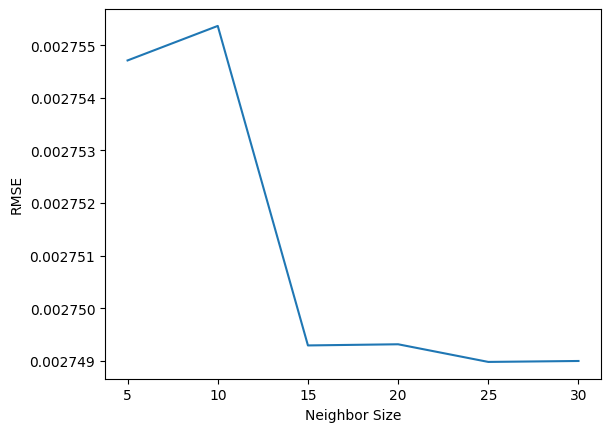

In [11]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(Neighbor_size, RMSE_by_K)
plt.xlabel('Neighbor Size')
plt.ylabel('RMSE')
plt.show()

In [12]:
RMSE_by_K = []
Neighbor_size = []
for K in range(13, 18, 1):
    RMSE_by_K.append(score(cf_knn, K))
    Neighbor_size.append(K)
print(RMSE_by_K)

[0.0027554079849318592, 0.0027487792369759725, 0.0027492908313713643, 0.0027493524862772737, 0.0027482892032481333]


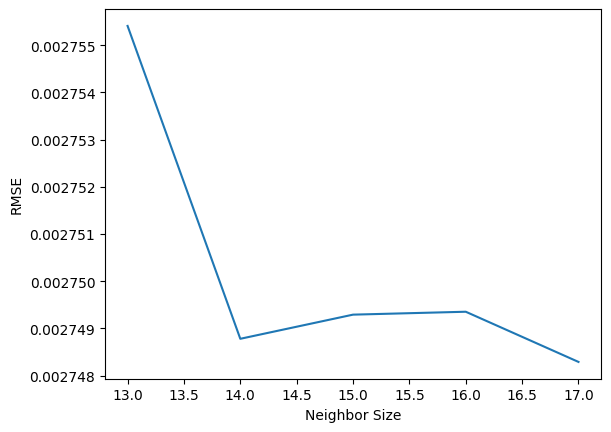

In [13]:
plt.plot(Neighbor_size, RMSE_by_K)
plt.xlabel('Neighbor Size')
plt.ylabel('RMSE')
plt.show()

#### --> 14일때 RMSE 최저

## ubcf_knn으로 추천해보기

In [15]:
ratings = ratings_all[ratings_all['year']==2012]
ratings = ratings[['country', '품목코드', 'preference']]
# column명 변경
ratings.columns=['country_id', 'item_id', 'preference']

# country에 고유번호 부여하기
country_to_idx = {v:k for k,v in enumerate(ratings['country_id'].unique())}
idx_to_country = {v:k for k,v in country_to_idx.items()}

# country_id를 고유번호로 바꾸기
ratings['country_id'] = ratings['country_id'].map(country_to_idx)

# item_id int로 바꾸기
ratings['item_id'] = ratings['item_id'].astype(int)

# 중복제거
ratings = ratings.drop_duplicates(['country_id', 'item_id'], keep='first')

# index reset
ratings.reset_index(drop=True, inplace=True)

# 품목 이름 가져오기
items_df = pd.read_csv('/home/sjkim/추천공모전/data/item_name-code.csv')
items_df.columns=['title', 'item_id']
items_df = items_df.set_index('item_id')

In [16]:
# Cosine similarity 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
country_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
country_similarity = pd.DataFrame(country_similarity, index=rating_matrix.index, columns=rating_matrix.index)

In [17]:
# 추천하기
def recommender(country, n_items=10, neighbor_size=11):                             # 주어진 국가와 유사도가 제일 높은 국가 k개를 써서 예측 rating이 높은 10개만 출력하기
    # 현재 사용자의 모든 아이템에 대한 예상 평점 계산
    predictions = []                                                                # 예상 선호도를 저장할 리스트 만들기
    rated_index = rating_matrix.loc[country][rating_matrix.loc[country] > 0].index  # 현재 국가에 선호도가 존재하는 품목 확인(추천에서 제외하기 위함)
    items = rating_matrix.loc[country].drop(rated_index)                            # 이미 선호도가 있는 품목은 제거
    for item in items.index:                                                        # 각 품목에 대한 해당 국가의 예상 선호도 계산
        predictions.append(cf_knn(country, item, neighbor_size))                    # cf_knn함수를 호출해서 해당 국가의 현재 품목에 대한 예상 선호도를 구해서 predictions에 추가
    recommendations = pd.Series(data=predictions, index=items.index, dtype=float)   # 예상 선호도를 series형태로 변환해서 recommendations에 저장
    recommendations = recommendations.sort_values(ascending=False)[:n_items]        # 예상 선호도가 높은 순서로 정렬해서 주어진 아이템 수(n_items)만큼 선택
    recommended_items = items_df.loc[recommendations.index]['title']                # 추천 품목의 title만 뽑아냄
    return recommended_items

In [29]:
recommender(1, 5, 16) # 1번 국가에 대해서 1번 국가와 비슷한 16개 나라를 이용하여 5개의 품목을 추천

item_id
39                                           플라스틱과 그 제품
72                                                   철강
27           광물성 연료ㆍ광물유(鑛物油)와 이들의 증류물, 역청(瀝靑)물질, 광물성 왁스
24    담배와 제조한 담배 대용물, 연소시키지 않고흡입하도록 만들어진 물품(니코틴을 함유하...
55                                             인조스테이플섬유
Name: title, dtype: object

### Precision@K

In [19]:
# precision@k 함수로 만들기
def precision_at_k(country, n_items, year, neighbor_size=11):
    hit_df = ratings_all[ratings_all['year'].isin(year)]
    hit_df = hit_df[hit_df['country']==idx_to_country[country]]
    c_items = hit_df['품목코드'].unique().astype(int)
    rec_items = recommender(country, n_items, neighbor_size).index.tolist()
    hit_items = [i for i in c_items if i in rec_items]
    precision = len(hit_items) / n_items
    return precision

In [20]:
# 해당년도 모든 나라에 대해서 precision@k 계산
def precision_at_k_all(n_items, year, neighbor_size):
    precision = []
    c_len = len(rating_matrix)
    for country in range(0, c_len):
        precision.append(precision_at_k(country, n_items, year, neighbor_size))
    return sum(precision) / c_len

### Recommender 최적 K(=neighbor size)값 찾기

In [21]:
year = [2013, 2014, 2015, 2016, 2017]

Precision_at_K = []
Neighbor_size = []
for K in range(5, 35, 5):
    Precision_at_K.append(precision_at_k_all(5, year, K))
    Neighbor_size.append(K)
print(Precision_at_K)

[0.8610837438423646, 0.8610837438423649, 0.8620689655172413, 0.85320197044335, 0.8482758620689658, 0.8463054187192118]


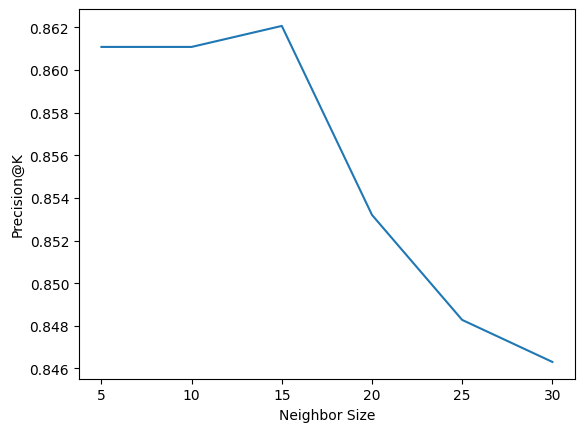

In [22]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(Neighbor_size, Precision_at_K)
plt.xlabel('Neighbor Size')
plt.ylabel('Precision@K')
plt.show()

In [25]:
year = [2013, 2014, 2015, 2016, 2017]

Precision_at_K = []
Neighbor_size = []
for K in range(10, 18, 1):
    Precision_at_K.append(precision_at_k_all(5, year, K))
    Neighbor_size.append(K)
print(Precision_at_K)

[0.8610837438423649, 0.8561576354679804, 0.8561576354679804, 0.8610837438423642, 0.8630541871921179, 0.8620689655172413, 0.8650246305418717, 0.8630541871921183]


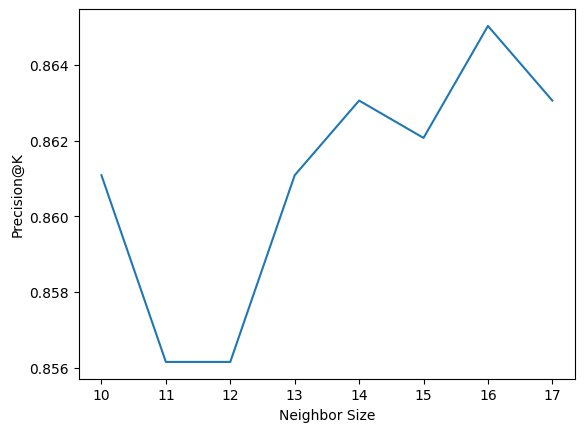

In [26]:
plt.plot(Neighbor_size, Precision_at_K)
plt.xlabel('Neighbor Size')
plt.ylabel('Precision@K')
plt.show()

#### --> 최적 K값 16

In [28]:
year = [2013, 2014, 2015]
precision_at_k_all(5, year, 16)

0.8226600985221674